# NLP method 2

Извлекаем отзывы из облачного хранилища, которые соответствуют запросу

In [ ]:
# Текст запроса
query = 'кофе'
query_vector = retriever.encode(query).tolist()

# Выполнение запроса
results = index.query(
    vector=query_vector,  # Вектор запроса
    top_k=1149,
    include_metadata=True
)

cafe = [result['metadata']['Кофейня'] for result in results['matches']]
rating = [result['metadata']['Рейтинг'] for result in results['matches']]
date = [result['metadata']['Дата'] for result in results['matches']]
ru_review = [result['metadata']['Отзыв'] for result in results['matches']]
en_review = [result['metadata']['Отзыв_англ'] for result in results['matches']]
sentiment = [result['metadata']['sentiment'] for result in results['matches']]
score = [result['metadata']['score'] for result in results['matches']]

In [ ]:
columns = ['Кофейня', 'Рейтинг', 'Дата', 'Отзыв', 'Отзыв_англ', 'sentiment', 'score']

results_df = pd.DataFrame(columns=columns)

# Добавление полученных данных в датафрейм
results_df['Кофейня'] = cafe
results_df['Рейтинг'] = rating
results_df['Дата'] = date
results_df['Отзыв'] = ru_review
results_df['Отзыв_англ'] = en_review
results_df['sentiment'] = sentiment
results_df['score'] = score
results_df.tail()

,Кофейня,Рейтинг,Дата,Отзыв,Отзыв_англ,sentiment,score
571,Surf Coffee,5,2019-02-05,это место покорить ваш сердечко отличный зерно...,place win heart Excellent grain large selectio...,позитивный,0.903977
572,Star Hit Cafe,4,2022-04-27,кто самый я ничто зацепиться ни еда самообслуж...,people right there s nothing stand neither foo...,негативный,0.579293
573,Star Hit Cafe,4,2022-05-22,цена качество хороший целое средне,pricequality good overall average,нейтральный,0.475220
574,Prime,3,2019-03-06,очень скромный ассортимент наличие не убрать с...,modest range availability Uncleaned table,нейтральный,0.687490
575,Prime,1,2023-08-15,брать цезарь ролл что ствол дерево вместо сала...,order Caesar roll kind tree trunk instead lett...,нейтральный,0.746082


Проиндексировали все отзывы клиентов и соответствующие метаданные.

Определим несколько аспектов, которые клиенты обычно учитывают при выборе кофейни, и проанализируем общее мнение клиентов.

Можем искать по любой теме и получать отзывы клиентов, соответствующие поисковому запросу, вместе с метками настроений в качестве метаданных.

Мы начнем с общего вопроса о качестве кофе и вернем 500 лучших отзывов по данному аспекту

In [ ]:
query = "Довольны ли клиенты качеством кофе?"
# кенерация ембединга для запроса
query_vector = retriever.encode(query).tolist()
# запрос к пайнкод
result = index.query(vector=query_vector, top_k=500, include_metadata=True)

Парочка отзывов из результатов поиска.

In [ ]:
result["matches"][:2]

[{'id': '502',
  'metadata': {'score': 0.7439531087875366,
               'sentiment': 'позитивный',
               'timestamp': 1657152000.0,
               'Дата': '2022-07-07',
               'Кофейня': 'Star Hit Cafe',
               'Отзыв': 'хороший заведение москва',
               'Отзыв_англ': 'good establishment Moscow',
               'Рейтинг': '5'},
  'score': 0.409206957,
  'values': []},
 {'id': '163',
  'metadata': {'score': 0.9031267762184143,
               'sentiment': 'позитивный',
               'timestamp': 1685318400.0,
               'Дата': '2023-05-29',
               'Кофейня': 'Surf Coffee',
               'Отзыв': 'кофейня совместно пиццерия уютный место кофе хороший '
                        'москве👌',
               'Отзыв_англ': 'coffee shop pizzeria Cozy place good coffee Surf '
                             'Moscow 👌',
               'Рейтинг': '5'},
  'score': 0.324255139,
  'values': []}]

У нас есть отзывы, которые содержат упоминания качества кофе: при этом в результате матч ранжируется по убыванию.

Теперь посмотрим на общее восприятие клиентами.

Сначала нам нужно извлечь метки настроений из результатов запроса и посчитать их.

In [ ]:
def count_sentiment(result):
    # инициализация счетчиков для мнений
    sentiments = {
        "негативный": 0,
        "нейтральный": 0,
        "позитивный": 0,
    }
    # итерация по каждому матчу
    for r in result["matches"]:
        # извлечь метку настроения и увеличить ее количество
        sentiments[r["metadata"]["sentiment"]] += 1
    return sentiments

сколько всего отзывов каждой категории

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'негативный': 68, 'нейтральный': 77, 'позитивный': 355}

In [ ]:
query = "Довольны ли клиенты?"
# кенерация ембединга для запроса
query_vector = retriever.encode(query).tolist()
# запрос к пайнкод
result = index.query(vector=query_vector, top_k=1153, include_metadata=True)

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'негативный': 74, 'нейтральный': 101, 'позитивный': 401}

<Axes: >

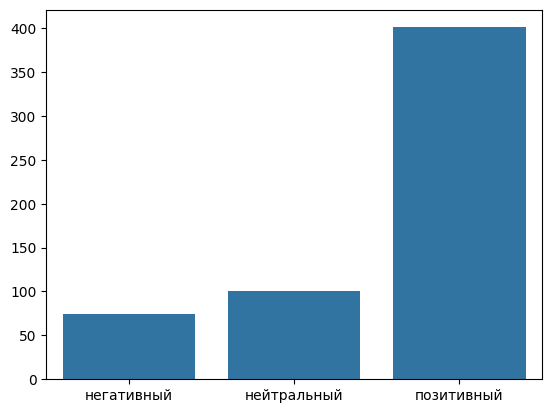

In [ ]:
import seaborn as sns
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

Клиенты чаще удовлетворены качеством кофе.

Мы можем конкретизировать поиск с помощью фильтрации метаданных Pinecone.
Например, указать период в нашем запросе, чтобы гарантировать, что результаты поиска будут содержать только отзывы за этот период. Это полезно, если хотите понять мнение клиента за определенный период.

Мы отфильтруем отзывы в заданный период для того же запроса, что и раньше. Ранее мы добавляли поле review_date в качестве временной метки в метаданные во время индексации.

Мы можем преобразовать начальную и конечную дату периода в временную метку с помощью функции get_timestamp и использовать фильтр $gte  (больше или равно) и $lte (меньше или равно), чтобы получить отзывы только за выбранный период.

In [ ]:
# генерируем временные метки для времени начала и окончания периода
start_time = get_timestamp(["2016-12-25"])[0]
end_time = get_timestamp(["2024-12-01"])[0]

<Axes: >

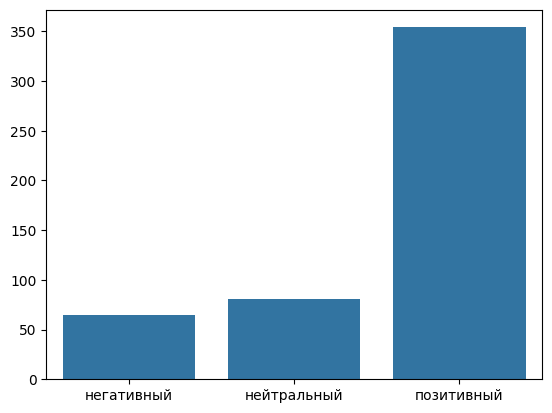

In [ ]:
query = "Довольны ли клиенты качеством туалета?"
query_vector = retriever.encode(query).tolist()

# делаем запрос к pinecone с ембедингом запроса и фильтром периода
result = index.query(
    vector=query_vector,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})

# получаем общий подсчет настроений клиентов
sentiment = count_sentiment(result)
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

In [ ]:
cafes =[
    "Star Hit Cafe",
    "Surf Coffee",
    "Prime",
]

queries = {
    "Кофе": "Нравится ли качество кофе?",
    "Атмосфера": "Удовлетворены ли клиенты вайбом или атмосферой помещения?",
    "Чистота": "Удовлетворены ли клиенты чистотой в помещениях?",
    "Персонал": "Нравится ли клиентам, как с ними обращаются сотрудники?",
    "Еда": "Нравится ли клиентам еда?",
}

Нам нужно пройтись по всем кофейням и выполнить эти запросы для каждой кофейни. Это даст нам отзывы клиентов, соответствующие выбранным аспектам мнений.

После этого мы подсчитываем метки настроений и выстраиваем графики результатов для каждой кофейни

In [ ]:
def count_sentiment(result):
    # инициализация счетчиков для мнений
    sentiments = {
        "негативный": 0,
        "нейтральный": 0,
        "позитивный": 0,
    }

    # итерация по каждому матчу
    for r in result["matches"]:
        # извлечь метку настроения и увеличить ее количество
        sentiments[r["metadata"]["sentiment"]] += 1

    return sentiments

In [ ]:
cafe_sentiments = []

# iterate through the cafes
for cafe in cafes:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the cafe filter
        xc = index.query(vector=xq, top_k=23, include_metadata=True, filter={"Кофейня": cafe})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)

        # sort the sentiment to show area and each value side by side
        for key, value in sentiment.items():
            data = {
                "area": area,
                "sentiment": key,
                "value": value
            }
            result.append(data)

    cafe_sentiments.append({"Кофейня": cafe, "df": pd.DataFrame(result)})
cafe_sentiments[0]["df"] # сколько оценок у первой кофейни

,area,sentiment,value
0,Кофе,негативный,4
1,Кофе,нейтральный,4
2,Кофе,позитивный,15
3,Атмосфера,негативный,5
4,Атмосфера,нейтральный,2
5,Атмосфера,позитивный,16
6,Чистота,негативный,7
7,Чистота,нейтральный,2
8,Чистота,позитивный,14
9,Персонал,негативный,4


## Method 2. Opinion mining

помогает консолидировать информацию из множества мнений, предоставляя общее представление о восприятии и эмоциях, связанных с объектом анализа по поводу каждого аспекта

​Opinion mining играет критическую роль в современном бизнесе, так как помогает извлекать ценные данные из больших объемов текста, позволяя компаниям принимать обоснованные решения на основе реальных мнений и эмоций клиентов​

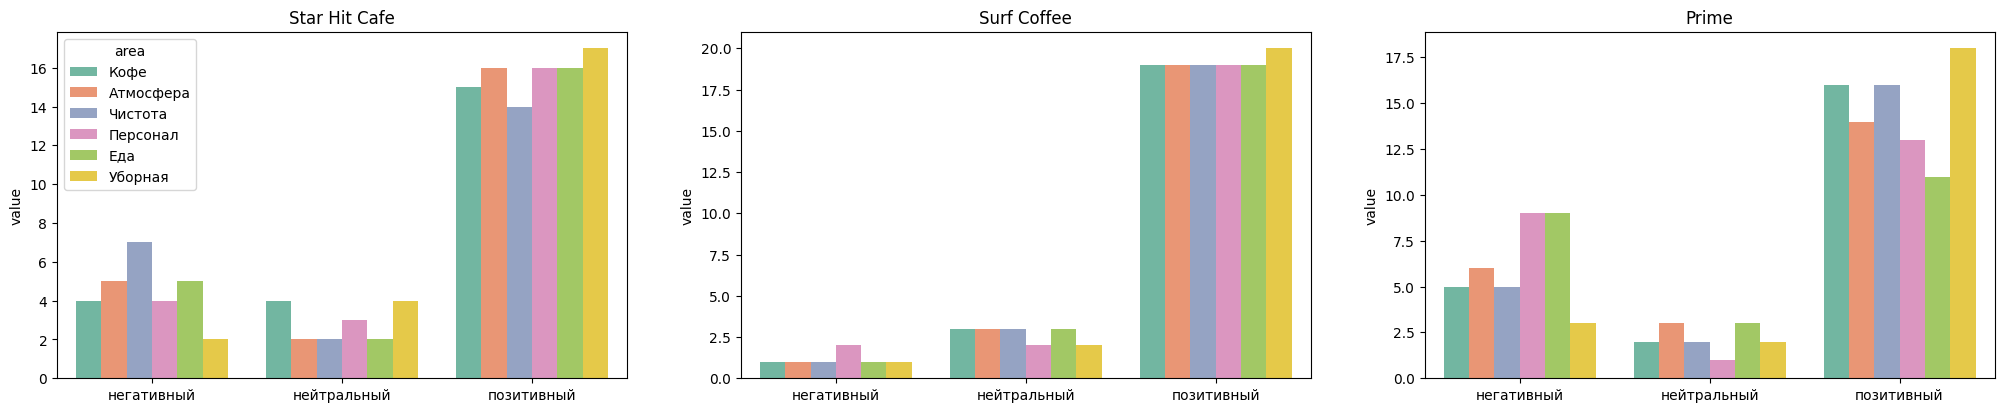

In [ ]:
# create the figure and axes to plot barchart for all hotels
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0

for d, ax in zip(cafe_sentiments, axs.ravel()):
    sns.barplot(x="sentiment", y="value", hue="area", data=d["df"], ax=ax, palette="Set2")
    ax.set_title(d["Кофейня"])
    ax.set_xlabel("")
    counter += 1
    if counter != 1: ax.get_legend().remove()

plt.show()

## Method 2. Creating a model that can forecast the tonality or rating of reviews.
**Другой подход к анализу текста: машинное обучение**

Суть: задача бинарной классификации

Важен прежде всего **рейтинг** (то, что сами пользователи оценивают сами) и **отзывы** (скрытые тенденции, которые выходят за рамки рейтинга: можно строить облака слов, анализировать основные темы и проводить анализ по интересующим категорям мнений, как выше)

Можно делать на основании предсказаний модели

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=2500)
X = cv.fit_transform(results_df['Отзыв']).toarray()

In [ ]:
results_df['sentiment'] = results_df['sentiment'].replace({'негативный' : 0})
results_df['sentiment'] = results_df['sentiment'].replace({'нейтральный': 0})
results_df['sentiment'] = results_df['sentiment'].replace({'позитивный': 1})

In [ ]:
results_df.tail()

,Кофейня,Рейтинг,Дата,Отзыв,Отзыв_англ,sentiment,score
571,Surf Coffee,5,2019-02-05,это место покорить ваш сердечко отличный зерно...,place win heart Excellent grain large selectio...,1,0.903977
572,Star Hit Cafe,4,2022-04-27,кто самый я ничто зацепиться ни еда самообслуж...,people right there s nothing stand neither foo...,0,0.579293
573,Star Hit Cafe,4,2022-05-22,цена качество хороший целое средне,pricequality good overall average,0,0.475220
574,Prime,3,2019-03-06,очень скромный ассортимент наличие не убрать с...,modest range availability Uncleaned table,0,0.687490
575,Prime,1,2023-08-15,брать цезарь ролл что ствол дерево вместо сала...,order Caesar roll kind tree trunk instead lett...,0,0.746082


Можно делать на основании рейтингов, которые ставят сами люди

In [ ]:
#1,2,3->negative(i.e 0)
all_preprocessed_reviews['Рейтинг'] = pd.to_numeric(all_preprocessed_reviews['Рейтинг'], errors='coerce')
all_preprocessed_reviews.loc[all_preprocessed_reviews['Рейтинг']<=3,'Рейтинг'] = 0

#4,5->positive(i.e 1)
all_preprocessed_reviews.loc[all_preprocessed_reviews['Рейтинг']>3,'Рейтинг'] = 1

In [ ]:
all_preprocessed_reviews.tail()

,Кофейня,Рейтинг,Отзыв,Отзыв_англ,Дата
1142,Surf Coffee,0,высокий цена маленький порция посредственный кофе,high price small portion mediocre coffee,2019-02-13
1144,Surf Coffee,1,любимый кофейня ♥️,favorite coffee shop ♥ ️,2019-12-11
1146,Surf Coffee,1,лето классный шезлонг двор,summer great sun lounger yard,2019-01-05
1147,Surf Coffee,1,большой какао овсяный молоко себя 🥤,large cocoa oat milk go 🥤,2019-06-12
1149,Surf Coffee,1,здесь зависнуть весь день,hang day long,2019-05-06


In [ ]:
from sklearn.model_selection import train_test_split

cv = TfidfVectorizer(max_features=2500)
X_initial = cv.fit_transform(all_preprocessed_reviews['Отзыв']).toarray()
x_train, x_test, y_train, y_test = train_test_split(X_initial,all_preprocessed_reviews['Рейтинг'],
                                                test_size=0.25 ,
                                                random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model=LogisticRegression()

#Model fitting
model.fit(x_train,y_train)

#testing the model
pred=model.predict(x_test)

#model accuracy
accuracy_score(y_test,pred)

0.8523985239852399

​Результат accuracy score 0.852 для логистической регрессии означает, что модель правильно классифицировала 85,2% всех наблюдений в тестовом наборе данных

 Значение 0.852 указывает на то, что логистическая регрессия демонстрирует высокий уровень точности при классификации данных. Это свидетельствует о том, что модель хорошо справляется с задачей различения классов в большинстве случаев

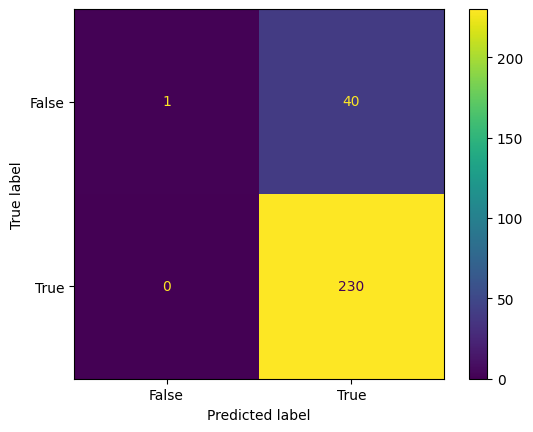

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = [False, True])

cm_display.plot()
plt.show()